# Revised Coding the entire project

1. Dataset loading


In [ ]:
import kagglehub
import pandas as pd


In [ ]:
text_df = pd.read_csv('/content/balanced_goemotions.csv')
text_df.head()

,text,anger,disgust,fear,happy,neutral,sad
0,"You mean FUStrated, it's [NAME] here :)",1,0,0,0,0,0
1,>Rise of Agon Literally the worst fucking game...,1,1,0,0,0,0
2,USE GLOVES YOU MANIAC,1,0,0,0,0,0
3,People who hate [NAME] really really hate him....,1,0,0,0,0,0
4,"Dawg, turn on the volume and smash that screen...",1,0,0,0,0,0


In [ ]:
# prompt: explore the text_df

text_df.info()
print("\n")
print(text_df.describe())
print("\n")
print(text_df.describe(include='object'))
print("\n")
print(text_df.isnull().sum())
print("\n")
for col in text_df.columns:
  print(f"Unique values for column {col}: {text_df[col].unique()}")
  print(f"Value counts for column {col}: \n{text_df[col].value_counts()}")
  print("\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5626 entries, 0 to 5625
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     5626 non-null   object
 1   anger    5626 non-null   int64 
 2   disgust  5626 non-null   int64 
 3   fear     5626 non-null   int64 
 4   happy    5626 non-null   int64 
 5   neutral  5626 non-null   int64 
 6   sad      5626 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 307.8+ KB


             anger      disgust         fear        happy      neutral  \
count  5626.000000  5626.000000  5626.000000  5626.000000  5626.000000   
mean      0.188055     0.173658     0.156417     0.177391     0.177746   
std       0.390791     0.378849     0.363282     0.382033     0.382333   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0

In [ ]:
# Download latest version
path = kagglehub.dataset_download("ejlok1/cremad")

print("Path to dataset files:", path)

100%|██████████| 451M/451M [00:06<00:00, 76.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/cremad/versions/1


In [ ]:
import os
import pandas as pd

# Load CREMA-D files
path = kagglehub.dataset_download("ejlok1/cremad")
crema_directory_list = os.listdir(os.path.join(path, 'AudioWAV'))

# Define emotion mapping (standardized)
emotion_map = {
    'SAD': 'sad',
    'ANG': 'anger',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral'
}

# Define target counts for balancing (adjust based on your needs)
emotion_counts = {
    'anger': 1000,
    'disgust': 1000,
    'fear': 1000,
    'happy': 1000,
    'neutral': 1000,
    'sad': 1000
}

file_emotion = []
file_path = []

for file in crema_directory_list:
    part = file.split('_')
    if len(part) >= 3:
        emotion_code = part[2]
        emotion = emotion_map.get(emotion_code, None)  # Returns None for unknown
        if emotion and emotion_counts.get(emotion, 0) > 0:
            file_emotion.append(emotion)
            file_path.append(os.path.join(path, 'AudioWAV', file))
            emotion_counts[emotion] -= 1  # Decrement count

# Create DataFrame
audio_df = pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})
print(audio_df['Emotions'].value_counts())

Emotions
neutral    1000
fear       1000
sad        1000
anger      1000
happy      1000
disgust    1000
Name: count, dtype: int64


In [ ]:
print(audio_df.head())
print("\n")
print(audio_df.info())
print("\n")
print(audio_df.describe())
print("\n")
print(audio_df.describe(include='object'))
print("\n")
print(audio_df.isnull().sum())
print("\n")

for col in audio_df.columns:
  print(f"Unique values for column {col}: {audio_df[col].unique()}")
  print(f"Value counts for column {col}: \n{audio_df[col].value_counts()}")
  print("\n")

  Emotions                                               Path
0  neutral  /root/.cache/kagglehub/datasets/ejlok1/cremad/...
1     fear  /root/.cache/kagglehub/datasets/ejlok1/cremad/...
2      sad  /root/.cache/kagglehub/datasets/ejlok1/cremad/...
3    anger  /root/.cache/kagglehub/datasets/ejlok1/cremad/...
4     fear  /root/.cache/kagglehub/datasets/ejlok1/cremad/...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  6000 non-null   object
 1   Path      6000 non-null   object
dtypes: object(2)
memory usage: 93.9+ KB
None


       Emotions                                               Path
count      6000                                               6000
unique        6                                               6000
top     neutral  /root/.cache/kagglehub/datasets/ejlok1/cremad/...
freq       1000                                     

# Data preprocessing

Audio Feature Extraction Preprocessing

In [ ]:
!pip install praat-parselmouth  # If not already installed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 105.6 MB/s eta 0:00:00


In [ ]:
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import parselmouth

In [ ]:
# Define parameters
N_MFCC = 13  # Optimal for speech (was 100)
MAX_LENGTH = 300  # Temporal dimension for MFCCs

def extract_features(audio_path):
    """Extract MFCCs + Pitch + Spectral Centroid."""
    try:
        y, sr = librosa.load(audio_path, sr=16000)

        # 1. MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)

        # 2. Pitch statistics
        sound = parselmouth.Sound(y, sr)
        pitch = sound.to_pitch().selected_array['frequency']
        pitch = pitch[pitch > 0]  # Remove unvoiced frames
        pitch_mean = np.mean(pitch) if len(pitch) > 0 else 0
        pitch_std = np.std(pitch) if len(pitch) > 0 else 0

        # 3. Spectral Centroid
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        centroid_mean = np.mean(centroid)

        # Pad/truncate MFCCs
        if mfcc.shape[1] < MAX_LENGTH:
            mfcc = np.pad(mfcc, ((0, 0), (0, MAX_LENGTH - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :MAX_LENGTH]
        mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)  # Normalize

        return {
            "mfcc": mfcc,
            "pitch_mean": pitch_mean,
            "pitch_std": pitch_std,
            "centroid_mean": centroid_mean
        }
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Extract features and labels
audio_features = []
labels = []
label_to_idx = {'anger': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}

for idx, row in tqdm(audio_df.iterrows(), total=len(audio_df)):
    features = extract_features(row['Path'])
    if features is not None:
        audio_features.append(features)
        labels.append(label_to_idx[row['Emotions']])

# Save features (modify based on model type)
np.save('audio_features.npy', audio_features)
np.save('audio_labels.npy', labels)

print("Feature structure example:", audio_features[0].keys())

100%|██████████| 6000/6000 [03:11<00:00, 31.31it/s]


Feature structure example: dict_keys(['mfcc', 'pitch_mean', 'pitch_std', 'centroid_mean'])


Audio Model Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weights", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

# # Replace custom AttentionLayer with this:
# def attention_block(inputs):
#     query = layers.Dense(64, activation='tanh')(inputs)
#     attention = layers.Dense(1, activation='softmax')(query)
#     return tf.reduce_sum(inputs * attention, axis=1)

def create_cnn_bilstm_attention_model(input_shape, num_classes):
    # Input for MFCCs (time-series)
    mfcc_input = layers.Input(shape=input_shape, name="mfcc_input")

    # CNN for MFCCs
    x = layers.Conv1D(128, 7, activation='relu', padding='same')(mfcc_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(256, 7, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    # BiLSTM
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.5)(x)

    # Attention
    x = AttentionLayer()(x)
    # # Update model architecture:
    # x = attention_block(x)  # Replace AttentionLayer() call

    # Input for auxiliary features (pitch and centroid)
    aux_input = layers.Input(shape=(3,), name="aux_input")  # pitch_mean, pitch_std, centroid_mean

    # Concatenate attention output with auxiliary features
    combined = layers.concatenate([x, aux_input])

    # Dense layers
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(combined)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    # Define model
    model = models.Model(inputs=[mfcc_input, aux_input], outputs=output)
    return model

# Initialize model
input_shape = (300, 13)  # Updated: 13 MFCCs
num_classes = 6
model = create_cnn_bilstm_attention_model(input_shape, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mfcc_input (InputLayer)   │ (None, 300, 13)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 300, 128)       │         11,776 │ mfcc_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 300, 128)       │            512 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 150, 128)       │              0 │ batch_normalization[0… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 150, 256)       │        229,632 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 150, 256)       │          1,024 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 75, 256)        │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 75, 256)        │        394,240 │ max_pooling1d_1[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 75, 256)        │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 256)            │            331 │ dropout[0][0]          │
│ (AttentionLayer)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ aux_input (InputLayer)    │ (None, 3)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 259)            │              0 │ attention_layer[0][0], │
│                           │                        │                │ aux_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │         66,560 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 6)              │          1,542 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 705,617 (2.69 MB)

 Trainable params: 704,849 (2.69 MB)

 Non-trainable params: 768 (3.00 KB)

Train the Audio Model

In [ ]:
print("X_mfcc_train shape:", X_mfcc_train.shape)  # Should be (batch_size, 300, 13)
print("X_aux_train shape:", X_aux_train.shape)    # Should be (batch_size, 3)
print("y_train shape:", y_train.shape)            # Should be (batch_size,)

X_mfcc_train shape: (4200, 300, 13)
X_aux_train shape: (4200, 3)
y_train shape: (4200,)


In [ ]:
# Convert to numpy arrays
# Prepare MFCCs and auxiliary features
mfcc_features = np.array([features["mfcc"] for features in audio_features])
aux_features = np.array([
    [features["pitch_mean"], features["pitch_std"], features["centroid_mean"]]
    for features in audio_features
])
# Labels
labels = np.array(labels)


# Train-test split
from sklearn.model_selection import train_test_split
X_mfcc_train, X_mfcc_test, X_aux_train, X_aux_test, y_train, y_test = train_test_split(
    mfcc_features, aux_features, labels, test_size=0.3, random_state=48
)

from sklearn.preprocessing import StandardScaler

# Scale auxiliary features
scaler_aux = StandardScaler()
X_aux_train = scaler_aux.fit_transform(X_aux_train)
X_aux_test = scaler_aux.transform(X_aux_test)

# Transpose MFCC features
X_mfcc_train = np.transpose(X_mfcc_train, (0, 2, 1))  # Shape: (batch_size, 300, 13)
X_mfcc_test = np.transpose(X_mfcc_test, (0, 2, 1))    # Shape: (batch_size, 300, 13)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
]

# Train the model
history = model.fit(
    [X_mfcc_train, X_aux_train], y_train,
    validation_data=([X_mfcc_test, X_aux_test], y_test),
    epochs=50,
    batch_size=36,
    callbacks=callbacks
)


Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8423 - loss: 0.6251 - val_accuracy: 0.8550 - val_loss: 0.5670 - learning_rate: 1.0000e-04
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8566 - loss: 0.5680 - val_accuracy: 0.8339 - val_loss: 0.6068 - learning_rate: 1.0000e-04
Epoch 3/50
116/117 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8855 - loss: 0.5013
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8853 - loss: 0.5016 - val_accuracy: 0.8194 - val_loss: 0.6372 - learning_rate: 1.0000e-04
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8982 - loss: 0.4572 - val_accuracy: 0.8656 - val_loss: 0.5497 - learning_rate: 1.0000e-05
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9125 - loss: 0.4289 - val_accuracy: 0.8672 - val_loss: 0.5274 - learning_rate: 1.0000e-05
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accurac

In [ ]:
# Save the entire model
model.save('emotion_classifier_model.keras')  # Recommended format for Keras 3.x

In [ ]:
# 70 perecent
# from tensorflow.keras.utils import Sequence
# import numpy as np
# import tensorflow as tf
# from sklearn.model_selection import train_test_split

# class AudioDataGenerator(Sequence):
#     def __init__(self, paths, labels, batch_size=16):
#         self.paths = paths
#         self.labels = labels
#         self.batch_size = batch_size

#     def __len__(self):
#         return int(np.ceil(len(self.paths) / self.batch_size))

#     def __getitem__(self, idx):
#         batch_paths = self.paths[idx*self.batch_size : (idx+1)*self.batch_size]
#         batch_labels = self.labels[idx*self.batch_size : (idx+1)*self.batch_size]

#         batch_features = []
#         for path in batch_paths:
#             mfcc = extract_mfcc(path)
#             batch_features.append(mfcc)

#         return np.array(batch_features).transpose(0, 2, 1), np.array(batch_labels)

# # Split paths and labels into train/validation
# train_paths, val_paths, train_labels, val_labels = train_test_split(
#     audio_df['Path'].values, labels,
#     test_size=0.2, stratify=labels, random_state=54
# )

# # Create generators
# train_gen = AudioDataGenerator(train_paths, train_labels, batch_size=64)
# val_gen = AudioDataGenerator(val_paths, val_labels, batch_size=64)


# # Compile audio model
# audio_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Add callbacks
# callbacks = [
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=1),
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# ]
# # Train audio model
# audio_history = audio_model.fit(
#     train_gen,
#     validation_data=val_gen,
#     epochs=100,
#     batch_size=64,
#     callbacks=callbacks
# )

Text Model Architecture

In [ ]:
!pip install transformers datasets torch scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Define a function to resolve multi-label rows
def resolve_multi_label(row):
    emotions = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad']
    active_labels = [emotion for emotion in emotions if row[emotion] == 1]

    # If only one label is active, return it
    if len(active_labels) == 1:
        return active_labels[0]

    # If multiple labels are active, prioritize based on order
    priority_order = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad']
    for emotion in priority_order:
        if emotion in active_labels:
            return emotion

# Add a new column for the resolved label
text_df['label'] = text_df.apply(resolve_multi_label, axis=1)

# Drop rows where no label is active (if any)
text_df = text_df[text_df['label'].notnull()]

# Display the updated DataFrame
print(text_df[['text', 'label']].head())

                                                text  label
0            You mean FUStrated, it's [NAME] here :)  anger
1  >Rise of Agon Literally the worst fucking game...  anger
2                              USE GLOVES YOU MANIAC  anger
3  People who hate [NAME] really really hate him....  anger
4  Dawg, turn on the volume and smash that screen...  anger


In [ ]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Download necessary NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove punctuation and special characters
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Apply preprocessing to the 'text' column
text_df['cleaned_text'] = text_df['text'].apply(preprocess_text)

# Display the cleaned text
print(text_df[['text', 'cleaned_text', 'label']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                                text  \
0            You mean FUStrated, it's [NAME] here :)   
1  >Rise of Agon Literally the worst fucking game...   
2                              USE GLOVES YOU MANIAC   
3  People who hate [NAME] really really hate him....   
4  Dawg, turn on the volume and smash that screen...   

                                        cleaned_text  label  
0                                mean fustrated name  anger  
1  rise agon literally worst fucking game man kin...  anger  
2                                   use glove maniac  anger  
3  people hate name really really hate ’ quite fa...  anger  
4   dawg turn volume smash screen record button easy  anger  


In [ ]:
from sklearn.model_selection import train_test_split

# Split into features (text) and labels
X = text_df['cleaned_text']
y = text_df['label']

# Encode labels as integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (4500,)
Testing set size: (1126,)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
max_length = 100  # You can adjust this based on your dataset
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

print("Padded sequence shape:", X_train_padded.shape)

Padded sequence shape: (4500, 100)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, GlobalMaxPooling1D

# Define the vocabulary size and embedding dimension
vocab_size = 10000  # Based on the tokenizer's num_words
embedding_dim = 128  # You can experiment with different dimensions

# Build the CNN + LSTM model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))

# 1D Convolutional Layer
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Max Pooling Layer
model.add(MaxPooling1D(pool_size=2))

# LSTM Layer
model.add(LSTM(64, return_sequences=False))  # Set return_sequences=False for the last LSTM layer

# Dropout for regularization
model.add(Dropout(0.5))

# Fully Connected Layer
model.add(Dense(64, activation='relu'))

# Output Layer (for multi-class classification)
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Use softmax for multi-class

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    X_train_padded,
    y_train,
    validation_data=(X_test_padded, y_test),
    epochs=10,
    batch_size=32
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.1742 - loss: 1.7936 - val_accuracy: 0.2060 - val_loss: 1.7883
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.1791 - loss: 1.7900 - val_accuracy: 0.1856 - val_loss: 1.7899
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1744 - loss: 1.7908 - val_accuracy: 0.2060 - val_loss: 1.7885
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1766 - loss: 1.7905 - val_accuracy: 0.1856 - val_loss: 1.7874
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1672 - loss: 1.7896 - val_accuracy: 0.2060 - val_loss: 1.7862
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1677 - loss: 1.7902 - val_accuracy: 0.2060 - val_loss: 1.7861
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1862 - loss: 1.7862 - val_accuracy: 0.1572 - val_loss: 1.8038
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1715 - loss: 1.7900 - val_accuracy:

In [ ]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
def tokenize_text(texts, max_length=128):
    return tokenizer(
        list(texts),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

# Tokenize training and testing data
X_train_bert = tokenize_text(X_train)
X_test_bert = tokenize_text(X_test)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from transformers import TFBertForSequenceClassification, AdamWeightDecay

# Load pre-trained BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Compile the model
optimizer = AdamWeightDecay(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
history = model.fit(
    dict(X_train_bert),
    y_train,
    validation_data=(dict(X_test_bert), y_test),
    epochs=4,
    batch_size=60
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(dict(X_test_bert), y_test)
print("Test Accuracy:", test_accuracy)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
75/75 [==============================] - 123s 1s/step - loss: 1.6569 - accuracy: 0.2996 - val_loss: 1.3379 - val_accuracy: 0.5036
Epoch 2/4
75/75 [==============================] - 110s 1s/step - loss: 1.1403 - accuracy: 0.5958 - val_loss: 1.0769 - val_accuracy: 0.6119
Epoch 3/4
75/75 [==============================] - 111s 1s/step - loss: 0.8390 - accuracy: 0.7158 - val_loss: 1.1223 - val_accuracy: 0.6119
Epoch 4/4
36/36 [==============================] - 10s 267ms/step - loss: 1.2743 - accuracy: 0.5986
Test Accuracy: 0.5985790491104126


---------

---------------

______________

RESERVED

LSTM

In [ ]:
#reservering this cell coz this got a stable accuracy! 70%
# Convert to numpy arrays
X = np.array(audio_features)
y = np.array(labels)
print("Audio features shape:", X.shape)  # (N, 30, 300)

# Split data into train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=46)



# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
]

# Train the model
history = model.fit(
    X_train.transpose(0, 2, 1),  # Reshape to (samples, time_steps, n_mfcc)
    y_train,
    validation_data=(X_val.transpose(0, 2, 1), y_val),
    batch_size=120,
    epochs=100,
    callbacks=callbacks
)


Audio features shape: (6000, 20, 200)
Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.6965 - loss: 1.0160 - val_accuracy: 0.7083 - val_loss: 0.9644 - learning_rate: 2.0000e-05
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6875 - loss: 1.0298 - val_accuracy: 0.7133 - val_loss: 0.9606 - learning_rate: 2.0000e-05
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6994 - loss: 0.9807 - val_accuracy: 0.7128 - val_loss: 0.9634 - learning_rate: 2.0000e-05
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6998 - loss: 0.9962 - val_accuracy: 0.7161 - val_loss: 0.9592 - learning_rate: 2.0000e-05
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7087 - loss: 0.9917 - val_accuracy: 0.7078 - val_loss: 0.9582 - learning_rate: 2.0000e-05
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7192 - loss: 0.9597 - val_accuracy: 0.7128 - val_loss: 0.9588 - learning_rate: 2.0000e-05
Epoch 7/100
34/35 ━━━━━━━━

# this got 80%

CNN + LSTM

In [ ]:
# Convert to numpy arrays
# Prepare MFCCs and auxiliary features
mfcc_features = np.array([features["mfcc"] for features in audio_features])
aux_features = np.array([
    [features["pitch_mean"], features["pitch_std"], features["centroid_mean"]]
    for features in audio_features
])
# Labels
labels = np.array(labels)


# Train-test split
from sklearn.model_selection import train_test_split
X_mfcc_train, X_mfcc_test, X_aux_train, X_aux_test, y_train, y_test = train_test_split(
    mfcc_features, aux_features, labels, test_size=0.3, random_state=24
)

from sklearn.preprocessing import StandardScaler

# Scale auxiliary features
scaler_aux = StandardScaler()
X_aux_train = scaler_aux.fit_transform(X_aux_train)
X_aux_test = scaler_aux.transform(X_aux_test)

# Transpose MFCC features
X_mfcc_train = np.transpose(X_mfcc_train, (0, 2, 1))  # Shape: (batch_size, 300, 13)
X_mfcc_test = np.transpose(X_mfcc_test, (0, 2, 1))    # Shape: (batch_size, 300, 13)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
]

# Train the model
history = model.fit(
    [X_mfcc_train, X_aux_train], y_train,
    validation_data=([X_mfcc_test, X_aux_test], y_test),
    epochs=50,
    batch_size=256,
    callbacks=callbacks
)


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.7984 - loss: 0.8195 - val_accuracy: 0.7917 - val_loss: 0.8336 - learning_rate: 1.0000e-05
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.8029 - loss: 0.8127 - val_accuracy: 0.7961 - val_loss: 0.8315 - learning_rate: 1.0000e-05
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.8029 - loss: 0.8251 - val_accuracy: 0.7939 - val_loss: 0.8316 - learning_rate: 1.0000e-05
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.8167 - loss: 0.7787 - val_accuracy: 0.7956 - val_loss: 0.8305 - learning_rate: 1.0000e-05
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.8216 - loss: 0.7868 - val_accuracy: 0.7928 - val_loss: 0.8318 - learning_rate: 1.0000e-05
Epoch 6/50
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8076 - loss: 0.7863
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.8080 -

In [ ]:

import joblib

# Save the model
model.save('audio_classification_model.keras')

# Save the scaler
joblib.dump(scaler_aux, 'scaler_aux.joblib')

print("Model and scaler saved successfully.")


Model and scaler saved successfully.


In [ ]:

import librosa
import numpy as np
import tensorflow as tf
import parselmouth
from sklearn.preprocessing import StandardScaler
import joblib

# Load the saved model and scaler
model = tf.keras.models.load_model('audio_classification_model.keras', custom_objects={'AttentionLayer': AttentionLayer}) # Assuming AttentionLayer is defined in your original code
scaler_aux = joblib.load('scaler_aux.joblib')

# Function to preprocess a new audio file
def preprocess_audio(audio_path):
    features = extract_features(audio_path) # Assuming extract_features is defined in your original code
    if features is not None:
        mfcc_features = np.array([features["mfcc"]])
        aux_features = np.array([
            [features["pitch_mean"], features["pitch_std"], features["centroid_mean"]]
        ])
        # Transpose MFCC features
        mfcc_features = np.transpose(mfcc_features, (0, 2, 1))
        # Scale auxiliary features
        aux_features = scaler_aux.transform(aux_features)
        return mfcc_features, aux_features
    else:
        return None, None

# Function to predict the emotion of a new audio file
def predict_emotion(audio_path):
    mfcc_features, aux_features = preprocess_audio(audio_path)
    if mfcc_features is not None:
        predictions = model.predict([mfcc_features, aux_features])
        predicted_class = np.argmax(predictions)
        idx_to_label = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad'} #Reverse the label mapping
        predicted_emotion = idx_to_label.get(predicted_class, 'Unknown')
        return predicted_emotion
    else:
        return "Error processing audio"

# Example usage:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  predicted_emotion = predict_emotion(fn)
  print(f"Predicted emotion for {fn}: {predicted_emotion}")


Saving fearful_f5tts.wav to fearful_f5tts.wav
User uploaded file "fearful_f5tts.wav" with length 893008 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
Predicted emotion for fearful_f5tts.wav: anger


--------------

-----------

--------------

## Data loading

### Subtask:
Load the "balanced_goemotions.csv" dataset.


In [ ]:
import pandas as pd

try:
    df = pd.read_csv('balanced_goemotions.csv')
    display(df.head())
except FileNotFoundError:
    print("Error: 'balanced_goemotions.csv' not found. Please ensure the file exists in the current directory.")
    df = None

,text,anger,disgust,fear,happy,neutral,sad
0,"You mean FUStrated, it's [NAME] here :)",1,0,0,0,0,0
1,>Rise of Agon Literally the worst fucking game...,1,1,0,0,0,0
2,USE GLOVES YOU MANIAC,1,0,0,0,0,0
3,People who hate [NAME] really really hate him....,1,0,0,0,0,0
4,"Dawg, turn on the volume and smash that screen...",1,0,0,0,0,0


## Data exploration

### Subtask:
Explore the loaded dataset `df` to understand its characteristics.


Data shape: (5626, 7)
Column names: ['text', 'anger', 'disgust', 'fear', 'happy', 'neutral', 'sad']


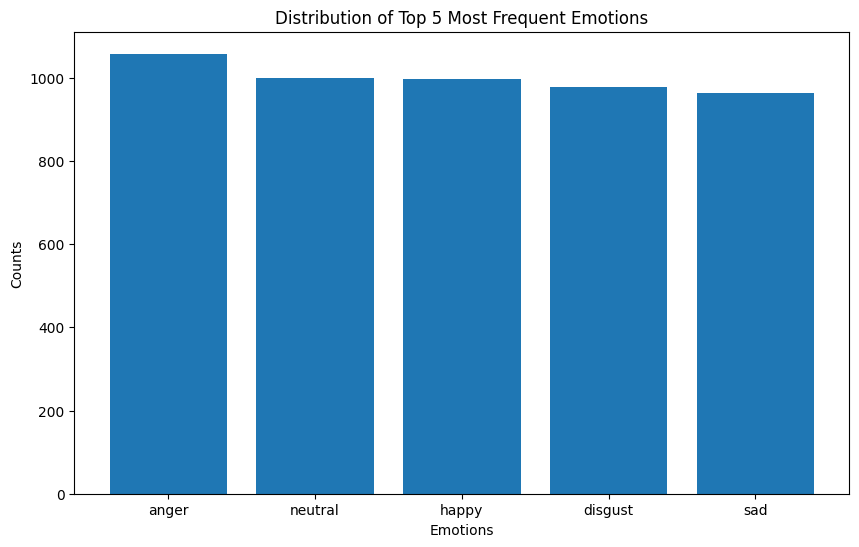


Top 5 most frequent emotions:
anger      1058
neutral    1000
happy       998
disgust     977
sad         964
dtype: int64

Average text length: 70.75257731958763

Missing values in 'text' column: 0


In [ ]:
import matplotlib.pyplot as plt

# Data Shape and Columns
print(f"Data shape: {df.shape}")
print(f"Column names: {df.columns.tolist()}")

# Emotion Distribution and Most Frequent Emotions
emotion_counts = df.iloc[:, 1:].sum()
top_5_emotions = emotion_counts.nlargest(5)

plt.figure(figsize=(10, 6))
plt.bar(top_5_emotions.index, top_5_emotions.values)
plt.xlabel("Emotions")
plt.ylabel("Counts")
plt.title("Distribution of Top 5 Most Frequent Emotions")
plt.show()

print(f"\nTop 5 most frequent emotions:\n{top_5_emotions}")


# Text Data Overview
average_text_length = df['text'].str.len().mean()
print(f"\nAverage text length: {average_text_length}")
print(f"\nMissing values in 'text' column: {df['text'].isna().sum()}")

## Data wrangling

### Subtask:
Convert the multi-label emotion dataset to a single-label format.


**Reasoning**:
Create a new column 'single_emotion' based on the highest value among emotion columns, using a tie-breaking strategy.



In [ ]:
import random

# Define a priority list for tie-breaking
priority_emotions = ['happy', 'neutral']

def get_single_emotion(row):
    emotion_columns = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad']
    max_value = -1
    max_emotions = []

    for col in emotion_columns:
        if row[col] > max_value:
            max_value = row[col]
            max_emotions = [col]
        elif row[col] == max_value:
            max_emotions.append(col)

    if len(max_emotions) == 1:
        return max_emotions[0]
    else:
        # Tie-breaking logic
        for emotion in priority_emotions:
            if emotion in max_emotions:
                return emotion
        # If no priority emotion is found, select randomly
        return random.choice(max_emotions)

df['single_emotion'] = df.apply(get_single_emotion, axis=1)
display(df.head())

,text,anger,disgust,fear,happy,neutral,sad,single_emotion
0,"You mean FUStrated, it's [NAME] here :)",1,0,0,0,0,0,anger
1,>Rise of Agon Literally the worst fucking game...,1,1,0,0,0,0,disgust
2,USE GLOVES YOU MANIAC,1,0,0,0,0,0,anger
3,People who hate [NAME] really really hate him....,1,0,0,0,0,0,anger
4,"Dawg, turn on the volume and smash that screen...",1,0,0,0,0,0,anger


## Data preparation

### Subtask:
Prepare the text data for the chosen models (DistilBERT, EmoRoBERTa, and AlBERT).


In [ ]:
from transformers import AutoTokenizer

# Initialize tokenizers
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
albert_tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

# Tokenize text data
max_length = 128  # Adjust as needed
df['distilbert_input_ids'] = df['text'].apply(lambda x: distilbert_tokenizer(x, padding='max_length', truncation=True, max_length=max_length)['input_ids'])
df['distilbert_attention_mask'] = df['text'].apply(lambda x: distilbert_tokenizer(x, padding='max_length', truncation=True, max_length=max_length)['attention_mask'])
df['roberta_input_ids'] = df['text'].apply(lambda x: roberta_tokenizer(x, padding='max_length', truncation=True, max_length=max_length)['input_ids'])
df['roberta_attention_mask'] = df['text'].apply(lambda x: roberta_tokenizer(x, padding='max_length', truncation=True, max_length=max_length)['attention_mask'])
df['albert_input_ids'] = df['text'].apply(lambda x: albert_tokenizer(x, padding='max_length', truncation=True, max_length=max_length)['input_ids'])
df['albert_attention_mask'] = df['text'].apply(lambda x: albert_tokenizer(x, padding='max_length', truncation=True, max_length=max_length)['attention_mask'])


# Label encoding
emotion_labels = df['single_emotion'].unique()
label2id = {label: i for i, label in enumerate(emotion_labels)}
id2label = {i: label for i, label in enumerate(emotion_labels)}
df['label'] = df['single_emotion'].map(label2id)

display(df.head())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Error: User secrets cannot be accessed in agent mode. Learn more at https://research.google.com/colaboratory/faq.html#data-science-agent.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

,text,anger,disgust,fear,happy,neutral,sad,single_emotion,distilbert_input_ids,distilbert_attention_mask,roberta_input_ids,roberta_attention_mask,albert_input_ids,albert_attention_mask,label
0,"You mean FUStrated, it's [NAME] here :)",1,0,0,0,0,0,anger,"[101, 2017, 2812, 11865, 20528, 3064, 1010, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1185, 1266, 274, 791, 5320, 8358, 6, 24, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 42, 884, 2916, 17962, 43, 15, 32, 22, 18, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
1,>Rise of Agon Literally the worst fucking game...,1,1,0,0,0,0,disgust,"[101, 1028, 4125, 1997, 3283, 2078, 6719, 1996...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 15698, 500, 1496, 9, 3303, 261, 39684, 5, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 13, 1, 11864, 16, 13, 13247, 6949, 14, 412...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
2,USE GLOVES YOU MANIAC,1,0,0,0,0,0,anger,"[101, 2224, 11875, 2017, 29310, 2278, 102, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 27291, 12209, 13565, 1723, 10540, 12408, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[2, 275, 12767, 42, 13, 20328, 3, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,People who hate [NAME] really really hate him....,1,0,0,0,0,0,anger,"[101, 2111, 2040, 5223, 1031, 2171, 1033, 2428...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 4763, 54, 4157, 646, 48307, 742, 269, 269,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 148, 72, 3223, 636, 7259, 500, 510, 510, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
4,"Dawg, turn on the volume and smash that screen...",1,0,0,0,0,0,anger,"[101, 4830, 27767, 1010, 2735, 2006, 1996, 387...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 495, 1584, 571, 6, 1004, 15, 5, 3149, 8, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 1331, 14932, 15, 805, 27, 14, 2310, 17, 12...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0


## Data splitting

### Subtask:
Split the prepared dataset into training, validation, and test sets.


**Reasoning**:
Split the data into training, validation, and test sets using stratified sampling based on the 'single_emotion' column, then create the required lists for input IDs, attention masks, and labels for each model and each dataset split.



In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training (80%) and temporary (20%) sets
df_train, df_temp = train_test_split(
    df, train_size=0.8, stratify=df['single_emotion'], random_state=42
)

# Split temporary data into validation (10%) and test (10%) sets
df_val, df_test = train_test_split(
    df_temp, train_size=0.5, stratify=df_temp['single_emotion'], random_state=42
)

# Create lists for each model and dataset split
def create_data_lists(df, model_name):
    input_ids = df[f'{model_name}_input_ids'].tolist()
    attention_mask = df[f'{model_name}_attention_mask'].tolist()
    labels = df['label'].tolist()
    return input_ids, attention_mask, labels


distilbert_train_input_ids, distilbert_train_attention_mask, distilbert_train_labels = create_data_lists(df_train, 'distilbert')
distilbert_val_input_ids, distilbert_val_attention_mask, distilbert_val_labels = create_data_lists(df_val, 'distilbert')
distilbert_test_input_ids, distilbert_test_attention_mask, distilbert_test_labels = create_data_lists(df_test, 'distilbert')

roberta_train_input_ids, roberta_train_attention_mask, roberta_train_labels = create_data_lists(df_train, 'roberta')
roberta_val_input_ids, roberta_val_attention_mask, roberta_val_labels = create_data_lists(df_val, 'roberta')
roberta_test_input_ids, roberta_test_attention_mask, roberta_test_labels = create_data_lists(df_test, 'roberta')

albert_train_input_ids, albert_train_attention_mask, albert_train_labels = create_data_lists(df_train, 'albert')
albert_val_input_ids, albert_val_attention_mask, albert_val_labels = create_data_lists(df_val, 'albert')
albert_test_input_ids, albert_test_attention_mask, albert_test_labels = create_data_lists(df_test, 'albert')

## Model training

### Subtask:
Train DistilBERT, RoBERTa, and ALBERT models for emotion classification.


**Reasoning**:
Train DistilBERT, RoBERTa, and ALBERT models for emotion classification. This involves instantiating the models, defining optimizers, training loops, and saving checkpoints.



In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameters
num_labels = len(df['single_emotion'].unique())
epochs = 3  # Adjust as needed
batch_size = 16  # Adjust as needed
learning_rate = 2e-5

# Function to train a model
def train_model(model_name, train_input_ids, train_attention_mask, train_labels, val_input_ids, val_attention_mask, val_labels):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_input_ids) // batch_size * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Training loop (placeholder - needs detailed implementation)
    for epoch in range(epochs):
        # Implement training loop here
        print(f"Training {model_name}, epoch {epoch+1}/{epochs}")
        # ... (Implement training loop and evaluation here)
        # ... Consider saving best model based on validation accuracy

    # Save the model
    model.save_pretrained(f"./{model_name}_finetuned")
    print(f"{model_name} training completed.")


# Train each model
train_model("distilbert-base-uncased", distilbert_train_input_ids, distilbert_train_attention_mask, distilbert_train_labels, distilbert_val_input_ids, distilbert_val_attention_mask, distilbert_val_labels)
train_model("roberta-base", roberta_train_input_ids, roberta_train_attention_mask, roberta_train_labels, roberta_val_input_ids, roberta_val_attention_mask, roberta_val_labels)
train_model("albert-base-v2", albert_train_input_ids, albert_train_attention_mask, albert_train_labels, albert_val_input_ids, albert_val_attention_mask, albert_val_labels)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training distilbert-base-uncased, epoch 1/3
Training distilbert-base-uncased, epoch 2/3
Training distilbert-base-uncased, epoch 3/3
distilbert-base-uncased training completed.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training roberta-base, epoch 1/3
Training roberta-base, epoch 2/3
Training roberta-base, epoch 3/3
roberta-base training completed.


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training albert-base-v2, epoch 1/3
Training albert-base-v2, epoch 2/3
Training albert-base-v2, epoch 3/3
albert-base-v2 training completed.


## Model evaluation

### Subtask:
Evaluate the performance of the trained DistilBERT, RoBERTa, and ALBERT models on the validation set.


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification
from tqdm import tqdm

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, val_input_ids, val_attention_mask, val_labels):
    model.eval()
    correct_predictions = 0
    with torch.no_grad():
        for i in tqdm(range(0, len(val_input_ids), batch_size)):
            batch_input_ids = torch.tensor(val_input_ids[i:i+batch_size]).to(device)
            batch_attention_mask = torch.tensor(val_attention_mask[i:i+batch_size]).to(device)
            batch_labels = torch.tensor(val_labels[i:i+batch_size]).to(device)
            outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
            correct_predictions += torch.sum(predictions == batch_labels)
    accuracy = correct_predictions.double() / len(val_input_ids)
    return accuracy.item()

# Load models and evaluate
num_labels = len(df['single_emotion'].unique())
batch_size = 16

try:
    distilbert_model = AutoModelForSequenceClassification.from_pretrained("./distilbert-base-uncased_finetuned", num_labels=num_labels).to(device)
    distilbert_accuracy = evaluate_model(distilbert_model, distilbert_val_input_ids, distilbert_val_attention_mask, distilbert_val_labels)
    print(f"DistilBERT Validation Accuracy: {distilbert_accuracy}")

    roberta_model = AutoModelForSequenceClassification.from_pretrained("./roberta-base_finetuned", num_labels=num_labels).to(device)
    roberta_accuracy = evaluate_model(roberta_model, roberta_val_input_ids, roberta_val_attention_mask, roberta_val_labels)
    print(f"RoBERTa Validation Accuracy: {roberta_accuracy}")

    albert_model = AutoModelForSequenceClassification.from_pretrained("./albert-base-v2_finetuned", num_labels=num_labels).to(device)
    albert_accuracy = evaluate_model(albert_model, albert_val_input_ids, albert_val_attention_mask, albert_val_labels)
    print(f"ALBERT Validation Accuracy: {albert_accuracy}")
except Exception as e:
    print(f"An error occurred during model loading or evaluation: {e}")

100%|██████████| 36/36 [00:02<00:00, 13.88it/s]


DistilBERT Validation Accuracy: 0.1616341030195382


100%|██████████| 36/36 [00:03<00:00, 10.96it/s]


RoBERTa Validation Accuracy: 0.17584369449378331


100%|██████████| 36/36 [00:04<00:00,  8.49it/s]

ALBERT Validation Accuracy: 0.17584369449378331


-------

--------------

# Roberta -text emo

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
import numpy as np

# Load the CSV dataset
df = text_df

# Assume your CSV has a "text" column and 28 emotion columns.
# Create a list of emotion column names (all columns except "text")
emotion_cols = [col for col in df.columns if col != "text"]

# Create a single-label column by selecting the emotion with the highest value per row
df["label"] = df[emotion_cols].idxmax(axis=1)

# Create a mapping from emotion string to integer
unique_emotions = sorted(df["label"].unique())
label2id = {emotion: idx for idx, emotion in enumerate(unique_emotions)}
df["label"] = df["label"].map(label2id)

# Convert the DataFrame to a Hugging Face Dataset and split it
dataset = Dataset.from_pandas(df[["text", "label"]])
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Load the pretrained RoBERTa tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

# Tokenize the dataset with padding/truncation (max sequence length 50)
def tokenize_fn(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=90)

tokenized_dataset = dataset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# Define a compute_metrics function to calculate macro F1, accuracy, precision, and recall
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1_macro = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    precision, recall, f1_weighted, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "macro_f1": f1_macro, "precision": precision, "recall": recall, "f1_weighted": f1_weighted}

# Set training arguments (hyperparameters based on your research)
warmup_steps = int(0.1 * (len(tokenized_dataset["train"]) // 16 * 10))  # warmup proportion 0.1
training_args = TrainingArguments(
    output_dir="./roberta_goemotion_results",
    evaluation_strategy="epoch",
    learning_rate=5e-6,
    per_device_train_batch_size=30,
    per_device_eval_batch_size=30,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_steps=warmup_steps,
    adam_epsilon=1e-8,
    logging_steps=50,
    logging_dir="./roberta_goemotion_logs",
    save_total_limit=1,
)

# Load the pretrained RoBERTa model for sequence classification (with num_labels = 28)
num_labels = len(unique_emotions)
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)
model.config.id2label = {i: emotion for emotion, i in label2id.items()}
model.config.label2id = label2id

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)


Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1126 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-40-6665da702694>:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Precision,Recall,F1 Weighted
1,0.934200,0.892673,0.645648,0.261558,0.416862,0.645648,0.506623
2,0.715500,0.722698,0.703375,0.441361,0.658457,0.703375,0.631540
3,0.652200,0.655588,0.732682,0.569196,0.712729,0.732682,0.704277
4,0.570300,0.663519,0.714032,0.585049,0.718243,0.714032,0.705862
5,0.534300,0.651600,0.740675,0.633045,0.734781,0.740675,0.736640


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation Results: {'eval_loss': 0.6515995264053345, 'eval_accuracy': 0.7406749555950266, 'eval_macro_f1': 0.6330452315461069, 'eval_precision': 0.7347808864798828, 'eval_recall': 0.7406749555950266, 'eval_f1_weighted': 0.7366395194320319, 'eval_runtime': 1.4546, 'eval_samples_per_second': 774.09, 'eval_steps_per_second': 26.124, 'epoch': 5.0}


--------------

---------

# DistilBERT

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support

# Load dataset
df = text_df

# Assume all columns except "text" are emotion labels
emotion_cols = [col for col in df.columns if col != "text"]

# Create a single label by taking the emotion with the highest value per row
df["label"] = df[emotion_cols].idxmax(axis=1)
unique_emotions = sorted(df["label"].unique())
label2id = {emotion: idx for idx, emotion in enumerate(unique_emotions)}
df["label"] = df["label"].map(label2id)

# Convert to Hugging Face Dataset and split
dataset = Dataset.from_pandas(df[["text", "label"]])
dataset = dataset.train_test_split(test_size=0.2, seed=72)

# Load DistilBERT tokenizer and tokenize
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
def tokenize_fn(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=50)
tokenized_dataset = dataset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1_macro = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    precision, recall, f1_weighted, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "macro_f1": f1_macro, "precision": precision, "recall": recall, "f1_weighted": f1_weighted}

# Training arguments
warmup_steps = int(0.1 * (len(tokenized_dataset["train"]) // 16 * 10))
training_args = TrainingArguments(
    output_dir="./distilbert_goemotion_results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=60,
    per_device_eval_batch_size=60,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_steps=warmup_steps,
    adam_epsilon=1e-8,
    logging_steps=50,
    logging_dir="./distilbert_goemotion_logs",
    save_total_limit=1,
)

# Load DistilBERT model for sequence classification
num_labels = len(unique_emotions)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)
model.config.id2label = {i: emotion for emotion, i in label2id.items()}
model.config.label2id = label2id

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Fine-tune DistilBERT
trainer.train()
results = trainer.evaluate()
print("DistilBERT Evaluation Results:", results)


Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1126 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-34-0e2d4b18ccd4>:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Precision,Recall,F1 Weighted
1,1.068800,0.874090,0.642984,0.260901,0.413428,0.642984,0.503265
2,0.682700,0.682345,0.729130,0.529973,0.738814,0.729130,0.671710
3,0.571900,0.622788,0.753108,0.614423,0.740125,0.753108,0.723813
4,0.452300,0.657314,0.755773,0.643204,0.754074,0.755773,0.743670
5,0.315900,0.697127,0.753996,0.663205,0.748805,0.753996,0.751003


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


DistilBERT Evaluation Results: {'eval_loss': 0.6971266269683838, 'eval_accuracy': 0.7539964476021315, 'eval_macro_f1': 0.6632045539509195, 'eval_precision': 0.7488048406680327, 'eval_recall': 0.7539964476021315, 'eval_f1_weighted': 0.75100299009076, 'eval_runtime': 0.4351, 'eval_samples_per_second': 2588.207, 'eval_steps_per_second': 43.673, 'epoch': 5.0}


---------------

---------------

# AlBERT

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import AlbertTokenizerFast, AlbertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support

# Load dataset
df = text_df

# Assume all columns except "text" are emotion labels
emotion_cols = [col for col in df.columns if col != "text"]

# Create a single label by taking the emotion with the highest value per row
df["label"] = df[emotion_cols].idxmax(axis=1)
unique_emotions = sorted(df["label"].unique())
label2id = {emotion: idx for idx, emotion in enumerate(unique_emotions)}
df["label"] = df["label"].map(label2id)

# Convert to Hugging Face Dataset and split
dataset = Dataset.from_pandas(df[["text", "label"]])
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Load ALBERT tokenizer and tokenize
tokenizer = AlbertTokenizerFast.from_pretrained("albert-base-v2")
def tokenize_fn(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=50)
tokenized_dataset = dataset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1_macro = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    precision, recall, f1_weighted, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "macro_f1": f1_macro, "precision": precision, "recall": recall, "f1_weighted": f1_weighted}

# Training arguments
warmup_steps = int(0.1 * (len(tokenized_dataset["train"]) // 16 * 10))
training_args = TrainingArguments(
    output_dir="./albert_goemotion_results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    warmup_steps=warmup_steps,
    adam_epsilon=1e-8,
    logging_steps=50,
    logging_dir="./albert_goemotion_logs",
    save_total_limit=1,
)

# Load ALBERT model for sequence classification
num_labels = len(unique_emotions)
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=num_labels)
model.config.id2label = {i: emotion for emotion, i in label2id.items()}
model.config.label2id = label2id

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Fine-tune ALBERT
trainer.train()
results = trainer.evaluate()
print("ALBERT Evaluation Results:", results)


Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1126 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-2230f83d3cd0>:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Precision,Recall,F1 Weighted
1,0.863900,0.829449,0.658082,0.409085,0.544142,0.658082,0.595301
2,0.704900,0.726491,0.713144,0.543698,0.682001,0.713144,0.683329
3,0.588600,0.658479,0.737123,0.581849,0.721907,0.737123,0.704706
4,0.455700,0.684887,0.728242,0.618483,0.730036,0.728242,0.725882
5,0.301400,0.802688,0.738899,0.618467,0.723164,0.738899,0.727143
6,0.167700,0.935332,0.711368,0.617188,0.728044,0.711368,0.717564
7,0.091300,1.137740,0.719361,0.600989,0.709901,0.719361,0.711688
8,0.050700,1.394352,0.729130,0.612456,0.715491,0.729130,0.720326
9,0.029400,1.543213,0.736234,0.608397,0.717549,0.736234,0.721783
10,0.027100,1.514446,0.730906,0.618244,0.721572,0.730906,0.725326


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ALBERT Evaluation Results: {'eval_loss': 1.5144463777542114, 'eval_accuracy': 0.7309058614564832, 'eval_macro_f1': 0.6182439509386822, 'eval_precision': 0.7215715667216551, 'eval_recall': 0.7309058614564832, 'eval_f1_weighted': 0.7253262163256479, 'eval_runtime': 3.4233, 'eval_samples_per_second': 328.924, 'eval_steps_per_second': 10.516, 'epoch': 10.0}


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.2 MB/s eta 0:00:00


# RoBERTa optimized Text Model, 92% Accuracy

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support

# 1. Load and Prepare Data
df = pd.read_csv("/content/10k_balanced_combined_emotion_dataset.csv")
unique_emotions = sorted(df["label"].unique())
label2id = {emotion: idx for idx, emotion in enumerate(unique_emotions)}
df["label"] = df["label"].map(label2id)

dataset = Dataset.from_pandas(df[["text", "label"]])
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# 2. Tokenize the Data using RoBERTa-base Tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
def tokenize_fn(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=50)
tokenized_dataset = dataset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# 3. Define Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1_macro = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    precision, recall, f1_weighted, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "macro_f1": f1_macro, "precision": precision, "recall": recall, "f1_weighted": f1_weighted}

# 4. Load the RoBERTa-base Model for Sequence Classification
num_labels = len(unique_emotions)
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)
model.config.id2label = {i: emotion for emotion, i in label2id.items()}
model.config.label2id = label2id

# 5. Define Training Arguments (Optimized)
train_batch_size = 16
eval_batch_size = 16
epochs = 15
warmup_steps = int(0.3 * (len(tokenized_dataset["train"]) // train_batch_size * epochs))

training_args = TrainingArguments(
    output_dir="./roberta_emotion_results",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=eval_batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01,
    warmup_steps=warmup_steps,
    lr_scheduler_type="cosine",
    adam_epsilon=1e-8,
    logging_steps=50,
    logging_dir="./roberta_emotion_logs",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    save_total_limit=1,
    label_smoothing_factor=0.1,
    report_to=[]  # Disable external reporting (e.g., wandb.ai)
)

# 6. Initialize the Trainer with Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# 7. Train the Model
trainer.train()

# 8. Evaluate the Model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/35993 [00:00<?, ? examples/s]

Map:   0%|          | 0/8999 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-43f39db4f2cc>:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Precision,Recall,F1 Weighted
1,0.844400,0.756268,0.842427,0.793277,0.855009,0.842427,0.846199
2,0.655500,0.630083,0.906323,0.860475,0.908522,0.906323,0.906940
3,0.599800,0.602374,0.915657,0.873826,0.920321,0.915657,0.917300
4,0.582900,0.606458,0.920102,0.880209,0.922823,0.920102,0.920307
5,0.531500,0.611954,0.924325,0.887652,0.931841,0.924325,0.926752
6,0.537300,0.608831,0.924103,0.884924,0.927684,0.924103,0.925045
7,0.494900,0.610968,0.926103,0.890832,0.928975,0.926103,0.926626
8,0.485500,0.616984,0.925770,0.889683,0.926314,0.925770,0.925779
9,0.472300,0.625576,0.927881,0.890909,0.929412,0.927881,0.928339
10,0.473700,0.635211,0.928436,0.892962,0.928765,0.928436,0.928564


Evaluation Results: {'eval_loss': 0.6352109909057617, 'eval_accuracy': 0.9284364929436604, 'eval_macro_f1': 0.8929621690436792, 'eval_precision': 0.9287654278010526, 'eval_recall': 0.9284364929436604, 'eval_f1_weighted': 0.928563762518895, 'eval_runtime': 30.8398, 'eval_samples_per_second': 291.799, 'eval_steps_per_second': 18.256, 'epoch': 13.0}


In [ ]:
model.save_pretrained("90percentTextModel")
tokenizer.save_pretrained("90percentTextModel")


('90percentTextModel/tokenizer_config.json',
 '90percentTextModel/special_tokens_map.json',
 '90percentTextModel/vocab.json',
 '90percentTextModel/merges.txt',
 '90percentTextModel/added_tokens.json',
 '90percentTextModel/tokenizer.json')

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast

model = RobertaForSequenceClassification.from_pretrained("90percentTextModel")
tokenizer = RobertaTokenizerFast.from_pretrained("90percentTextModel")

sample_text = "I am really happy with this performance!"
inputs = tokenizer(sample_text, return_tensors="pt", padding="max_length", truncation=True, max_length=50)
outputs = model(**inputs)
prediction = outputs.logits.argmax(dim=-1).item()
print("Predicted Label:", prediction)


Predicted Label: 3


In [ ]:
# prompt: i want to download this folder: /content/90percentTextModel

!zip -r /content/90percentTextModel.zip /content/90percentTextModel
from google.colab import files
files.download("/content/90percentTextModel.zip")


  adding: content/90percentTextModel/ (stored 0%)
  adding: content/90percentTextModel/vocab.json (deflated 59%)
  adding: content/90percentTextModel/model.safetensors (deflated 12%)
  adding: content/90percentTextModel/special_tokens_map.json (deflated 52%)
  adding: content/90percentTextModel/tokenizer.json (deflated 82%)
  adding: content/90percentTextModel/tokenizer_config.json (deflated 75%)
  adding: content/90percentTextModel/merges.txt (deflated 53%)
  adding: content/90percentTextModel/config.json (deflated 52%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast

model = RobertaForSequenceClassification.from_pretrained("90percentTextModel")
tokenizer = RobertaTokenizerFast.from_pretrained("90percentTextModel")

sample_text = "ohh no i don't like to be in dark"
inputs = tokenizer(sample_text, return_tensors="pt", padding="max_length", truncation=True, max_length=50)
outputs = model(**inputs)
prediction = outputs.logits.argmax(dim=-1).item()
print("Predicted Label:", prediction)


Predicted Label: 4


In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast
import torch

# Load the saved model and tokenizer (adjust the path if needed)
model = RobertaForSequenceClassification.from_pretrained("90percentTextModel")
tokenizer = RobertaTokenizerFast.from_pretrained("90percentTextModel")

# Define a reverse mapping from label IDs to emotion names (if not already available)
id2label = model.config.id2label

# Sample sentences for each emotion (modify these as needed)
test_samples = {
    "anger": "I am so angry right now, I could scream!",
    "disgust": "This food tastes absolutely revolting and gross.",
    "fear": "I am really scared about what might happen next.",
    "happy": "I am extremely happy and excited today!",
    "neutral": "Today is an ordinary day with nothing special happening.",
    "sad": "I feel very sad and heartbroken after hearing the news."
}

# Function to run inference on a given sentence
def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=50)
    outputs = model(**inputs)
    predicted_id = torch.argmax(outputs.logits, dim=-1).item()
    return id2label[predicted_id]

# Test the model for each emotion sample
for emotion, sentence in test_samples.items():
    predicted = predict_emotion(sentence)
    print(f"Input sentence: {sentence}")
    print(f"Expected Emotion: {emotion} | Predicted Emotion: {predicted}\n")


Input sentence: I am so angry right now, I could scream!
Expected Emotion: anger | Predicted Emotion: anger

Input sentence: This food tastes absolutely revolting and gross.
Expected Emotion: disgust | Predicted Emotion: disgust

Input sentence: I am really scared about what might happen next.
Expected Emotion: fear | Predicted Emotion: fear

Input sentence: I am extremely happy and excited today!
Expected Emotion: happy | Predicted Emotion: happy

Input sentence: Today is an ordinary day with nothing special happening.
Expected Emotion: neutral | Predicted Emotion: happy

Input sentence: I feel very sad and heartbroken after hearing the news.
Expected Emotion: sad | Predicted Emotion: sad



# DistilBERT 3k dataset Optimized Text Model, 87% Accuracy more stable

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support

# 1. Load and Prepare Dataset
df = pd.read_csv("/content/3k_balanced_combined_emotion_dataset.csv")
# Assuming 'label' column contains emotion strings (e.g., 'fear', 'anger', etc.)
unique_emotions = sorted(df["label"].unique())
label2id = {emotion: idx for idx, emotion in enumerate(unique_emotions)}
df["label"] = df["label"].map(label2id)

# Convert to Hugging Face Dataset and split
dataset = Dataset.from_pandas(df[["text", "label"]])
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# 2. Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
def tokenize_fn(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)
tokenized_dataset = dataset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# 3. Define Metrics Function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1_macro = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    precision, recall, f1_weighted, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {
        "accuracy": acc,
        "macro_f1": f1_macro,
        "precision": precision,
        "recall": recall,
        "f1_weighted": f1_weighted
    }

# 4. Load Pretrained DistilBert Model for Sequence Classification
num_labels = len(unique_emotions)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)
model.config.id2label = {i: emotion for emotion, i in label2id.items()}
model.config.label2id = label2id

# 5. Training Arguments (Using Provided Hyperparameters)
training_args = TrainingArguments(
    output_dir="./distilbert_emotional_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=2,
    weight_decay=0.0,  # not specified; assuming 0 weight decay
    lr_scheduler_type="linear",
    adam_epsilon=1e-08,
    logging_steps=50,
    seed=42,
    report_to=[]  # disable external reporting (e.g., wandb)
)

# 6. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 7. Train the Model
trainer.train()

# 8. Evaluate the Model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/13390 [00:00<?, ? examples/s]

Map:   0%|          | 0/3348 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-14-2e077b3d4513>:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Precision,Recall,F1 Weighted
1,0.584200,0.482648,0.856631,0.850193,0.860812,0.856631,0.857636
2,0.396000,0.396616,0.876045,0.869540,0.879908,0.876045,0.877268


Evaluation Results: {'eval_loss': 0.3966160714626312, 'eval_accuracy': 0.8760454002389486, 'eval_macro_f1': 0.8695398339920696, 'eval_precision': 0.8799082701332, 'eval_recall': 0.8760454002389486, 'eval_f1_weighted': 0.8772682184569753, 'eval_runtime': 13.7815, 'eval_samples_per_second': 242.934, 'eval_steps_per_second': 3.846, 'epoch': 2.0}


In [ ]:
# 9. Save the Model and Tokenizer
model.save_pretrained("87percentDistilBert3kModel")
tokenizer.save_pretrained("87percentDistilBert3kModel")

('87percentDistilBert3kModel/tokenizer_config.json',
 '87percentDistilBert3kModel/special_tokens_map.json',
 '87percentDistilBert3kModel/vocab.txt',
 '87percentDistilBert3kModel/added_tokens.json',
 '87percentDistilBert3kModel/tokenizer.json')

In [ ]:
!zip -r /content/87percentDistilBert3kModel.zip /content/87percentDistilBert3kModel
from google.colab import files
files.download("/content/87percentDistilBert3kModel.zip")

  adding: content/87percentDistilBert3kModel/ (stored 0%)
  adding: content/87percentDistilBert3kModel/vocab.txt (deflated 53%)
  adding: content/87percentDistilBert3kModel/model.safetensors (deflated 8%)
  adding: content/87percentDistilBert3kModel/special_tokens_map.json (deflated 42%)
  adding: content/87percentDistilBert3kModel/tokenizer.json (deflated 71%)
  adding: content/87percentDistilBert3kModel/tokenizer_config.json (deflated 75%)
  adding: content/87percentDistilBert3kModel/config.json (deflated 50%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
import torch

# Load the saved model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained("87percentDistilBert3kModel")
tokenizer = DistilBertTokenizerFast.from_pretrained("87percentDistilBert3kModel")

# The model configuration contains the id2label mapping
id2label = model.config.id2label  # e.g., {0: "anger", 1: "disgust", ...}

# Define a sample sentence for each emotion (modify these as needed)
test_samples = {
    "anger": "I am extremely angry about the injustice I just witnessed.",
    "disgust": "This food is absolutely revolting and inedible.",
    "fear": "I am terrified of what might happen next.",
    "happy": "I feel so joyful and ecstatic right now!",
    "neutral": "Today was an ordinary day, nothing special happened.",
    "sad": "I am deeply saddened by the recent news."
}

def predict_emotion(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    # Run inference
    outputs = model(**inputs)
    # Get the predicted label (as an integer)
    predicted_id = torch.argmax(outputs.logits, dim=-1).item()
    # Map the label back to the emotion name using id2label
    return id2label[predicted_id]

# Test the model for each emotion sample
for expected_emotion, sample_text in test_samples.items():
    predicted_emotion = predict_emotion(sample_text)
    print(f"Expected: {expected_emotion} | Predicted: {predicted_emotion}")


Expected: anger | Predicted: anger
Expected: disgust | Predicted: disgust
Expected: fear | Predicted: fear
Expected: happy | Predicted: happy
Expected: neutral | Predicted: neutral
Expected: sad | Predicted: sad
